# Modellierung 

In diesem Notebook wird die Modellierungsphase für die Betrugserkennung durchgeführt.
Der Fokus liegt auf einer robusten und reproduzierbaren Evaluierung unter Berücksichtigung
der stark unausgeglichenen Klassenverteilung.

Alle Merkmale wurden bereits im Preprocessing-Schritt bereinigt und transformiert.


In [37]:
# Grundlegende Bibliotheken
import numpy as np
import pandas as pd

# Visualisierung 
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report
)

#from src.models.train_model import *
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# XGBoost
from xgboost import XGBClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Pfad zu den vorverarbeiteten Daten
DATA_PATH = "../data/processed/training_preprocessed.csv"

# Laden der Daten
df = pd.read_csv(DATA_PATH)

print("Shape des Datensatzes:", df.shape)
df.head(10)

Shape des Datensatzes: (95456, 17)


,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450
5,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000.0,2000,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,7.601402,0.999500
6,ProviderId_5,ProductId_3,airtime,ChannelId_3,10000.0,10000,4,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.210440,0.999900
7,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-500.0,500,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.216606,0.998004
8,ProviderId_6,ProductId_10,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.866025,0.500000,0.433884,-0.900969,6.216606,0.998004
9,ProviderId_1,ProductId_15,financial_services,ChannelId_3,600.0,600,2,0,11,0,1,0.866025,0.500000,0.433884,-0.900969,6.398595,0.998336


In [39]:
# Features und Zielvariable trennen
TARGET = "FraudResult"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print("Shape der Feature-Matrix X:", X.shape)
print("Target-Verteilung:")
print(y.value_counts(normalize=True))

Shape der Feature-Matrix X: (95456, 16)
Target-Verteilung:
FraudResult
0    0.997978
1    0.002022
Name: proportion, dtype: float64


## **Train-Test-Split**


In diesem Schritt teilen wir den Datensatz in Trainings- und Testdaten auf. Dabei verwenden wir einen **stratifizierten Split**, um sicherzustellen, dass die Klassenverteilung in beiden Datensätzen (Trainings- und Testset) konstant bleibt. Dies ist besonders wichtig bei stark unausgeglichenen Datensätzen wie im Fall von Betrugserkennungsmodellen.

- **Trainingsset**: 80% der Daten, die für das Modelltraining verwendet werden.
- **Testset**: 20% der Daten, die zur finalen Evaluation des Modells dienen.


In [40]:
# Train/Test-Split(stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Shape von X_train:", X_train.shape)
print("Shape von X_test:", X_test.shape)


Shape von X_train: (76364, 16)
Shape von X_test: (19092, 16)


## **Evaluationsmetriken**

Aufgrund der starken Klassenunbalance sind Accuracy-basierte Metriken ungeeignet.
Verwendet werden daher:

- ROC-AUC (Trennschärfe)
- PR-AUC (Performance bei seltenen Klassen)
- Recall (Erkennungsrate von Betrugsfällen)
- F1-Score (Trade-off zwischen Precision und Recall)


In [41]:
# Definition der Metriken
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "recall": "recall",
    "f1": "f1"

}

## **Baseline: Logistic Regression**

Als Referenzmodell wird eine **logistische Regression** gewählt, da sie ein einfaches, effektives und leicht interpretierbares Modell für binäre Klassifikationsprobleme darstellt. Einige der Hauptgründe, warum die logistische Regression ausgewählt wurde, sind:

1. **Einfache Implementierung und schnelle Berechnungen**:
   Die logistische Regression ist sehr schnell zu implementieren und benötigt im Vergleich zu komplexeren Modellen weniger Rechenressourcen. Sie ist daher besonders nützlich bei großen Datensätzen, wenn schnelle Modellanpassungen erforderlich sind.

2. **Hohe Interpretierbarkeit**:
   Ein großer Vorteil der logistischen Regression ist ihre Transparenz. Sie ermöglicht eine direkte Interpretation der Beziehungen zwischen den Eingabefunktionen und der Zielvariablen. Dies ist besonders nützlich, wenn es darum geht, zu verstehen, wie verschiedene Merkmale die Wahrscheinlichkeit einer bestimmten Klassenzuordnung beeinflussen.

3. **Gute Leistung bei linearen Beziehungen**:
   Bei Problemen, bei denen eine lineare Beziehung zwischen den Eingabefunktionen und der Zielvariablen besteht, bietet die logistische Regression hervorragende Ergebnisse. Sie ist effizient und bietet eine gute Leistung, wenn die Annahmen des Modells erfüllt sind.


In [42]:
# Trennung der numerischen und kategorialen Merkmale
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing-Pipeline für numerische Merkmale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing-Pipeline für kategoriale Merkmale
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Kombinieren der Preprocessing-Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
logreg_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("classifier", LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000))
]) 

## **Cross-Validation mit StratifiedKFold**

Zur robusten Bewertung der Modellleistung wird eine stratifizierte Cross-Validation
mit 5 Folds verwendet.

Durch die Stratifikation bleibt die stark unausgeglichene Klassenverteilung
(Betrug vs. Nicht-Betrug) in jedem Fold erhalten.
Dies verhindert verzerrte Schätzungen der Modellgüte.

SMOTE wird dabei ausschließlich innerhalb der Trainings-Folds angewendet,
wodurch Datenlecks vermieden werden.



In [43]:
# Cross-Validation mit StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(logreg_pipeline, X_train, y_train, cv=cv, scoring=scoring)

# Ergebnisse der Cross-Validation anzeigen
# Ergebnisse zusammenfassen
cv_summary = pd.DataFrame({
    "ROC-AUC": cv_results["test_roc_auc"],
    "PR-AUC": cv_results["test_pr_auc"],
    "Recall": cv_results["test_recall"],
    "F1": cv_results["test_f1"]
})

display(cv_summary)

print("\nDurchschnittliche CV-Ergebnisse für Logistic Regression:")
display(cv_summary.mean())


,ROC-AUC,PR-AUC,Recall,F1
0,0.979412,0.667158,0.967742,0.441176
1,0.998544,0.680140,0.967742,0.394737
2,0.999054,0.639845,1.000000,0.369048
3,0.987982,0.750987,0.967742,0.394737
4,0.999151,0.824194,0.933333,0.366013



Durchschnittliche CV-Ergebnisse für Logistic Regression:


ROC-AUC    0.992829
PR-AUC     0.712465
Recall     0.967312
F1         0.393142
dtype: float64

## **Vergleichsmodell: Random Forest**
**Random Forest** wurde aufgrund seiner Robustheit und Vielseitigkeit bei der Modellierung von nichtlinearen Zusammenhängen und der Handhabung von großen, komplexen Datensätzen mit vielen Merkmalen gewählt. Diese Entscheidung wurde von mehreren Faktoren motiviert:
1. **Hervorragende Performance bei Klassifikationsaufgaben**:
   Random Forest ist besonders effektiv für Klassifikationsaufgaben, insbesondere wenn es um große und komplexe Datensätze geht. Es nutzt eine Vielzahl von Entscheidungsbäumen und aggregiert deren Ergebnisse, was zu einer besseren Generalisierung führt.

2. **Robustheit gegenüber Überanpassung**:
   Da Random Forest auf mehreren Bäumen basiert, ist es weniger anfällig für Überanpassung (Overfitting), was es besonders nützlich für unbalancierte Datensätze wie im Betrugsfall macht. Diese Eigenschaft hilft dabei, die Genauigkeit zu verbessern, ohne das Modell zu stark auf das Trainingsset anzupassen.

3. **Handhabung von unbalancierten Datensätzen**:
   Random Forest kann durch das Argument `class_weight="balanced"` die Klassengewichte anpassen, was besonders nützlich bei der Arbeit mit stark unbalancierten Datensätzen wie Betrugsfällen ist. Dies stellt sicher, dass das Modell nicht zu sehr auf die dominante Klasse ausgerichtet wird.

In [44]:
# pipeline für Random Forest
rf_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor), 
    ("smote", smote),
    ("classifier", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42))
])


In [45]:
# Cross-Validation mit StratifiedKFold fur Random Forest
cv_rf_results = cross_validate(rf_pipeline, X_train, y_train, cv=cv, scoring=scoring)

# Ergebnisse der Cross-Validation für Random Forest anzeigen
cv_rf_summary = pd.DataFrame({ 
    "ROC-AUC": cv_rf_results["test_roc_auc"],
    "PR-AUC": cv_rf_results["test_pr_auc"],
    "Recall": cv_rf_results["test_recall"],
    "F1": cv_rf_results["test_f1"]
})

display(cv_rf_summary)

print("\nDurchschnittliche CV-Ergebnisse für Random Forest:")
display(cv_rf_summary.mean())


,ROC-AUC,PR-AUC,Recall,F1
0,0.983498,0.916614,0.838710,0.881356
1,0.983360,0.867786,0.838710,0.812500
2,0.999465,0.915557,0.903226,0.835821
3,0.983385,0.775777,0.903226,0.811594
4,0.999904,0.936942,0.833333,0.877193



Durchschnittliche CV-Ergebnisse für Random Forest:


ROC-AUC    0.989922
PR-AUC     0.882535
Recall     0.863441
F1         0.843693
dtype: float64

## **Vergleichsmodell: XGBoost**

Als leistungsstärkeres Vergleichsmodell wird **XGBoost** eingesetzt, da es besonders gut geeignet ist, komplexe und nicht-lineare Zusammenhänge in großen und hochdimensionalen Datensätzen zu modellieren.
**XGBoost** (**Extreme Gradient Boosting**) basiert auf einem Ensemble von Entscheidungsbäumen, die sequentiell trainiert werden. Jeder neue Baum fokussiert sich gezielt auf die Fehler der vorherigen Modelle. Dadurch kann das Modell schwierige Entscheidungsgrenzen lernen, die mit linearen Modellen wie der Logistic Regression nicht erfasst werden können.

Ein wesentlicher Vorteil von **XGBoost** im Kontext der **Fraud Detection** ist seine hohe Robustheit gegenüber stark unausgeglichenen Klassenverteilungen. In diesem Projekt wird dieses Problem zusätzlich durch den Einsatz von **SMOTE** innerhalb der Pipeline adressiert, sodass das Modell während des Trainings ausreichend Beispiele der Minderheitsklasse (Fraud) sieht.

In [46]:

# Erstellung der pipeline mit XGBoost
xgb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  
    ("smote", smote),                
    ("classifier", XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=42))  
])


In [47]:
# Cross-Validation mit StratifiedKFold für XGBoost
cv_results_xgb = cross_validate(xgb_pipeline, X_train, y_train, cv=cv, scoring=scoring)

# Ergebnisse der Cross-Validation für XGBoost anzeigen
cv_summary_xgb = pd.DataFrame({
    "ROC-AUC": cv_results_xgb["test_roc_auc"],
    "PR-AUC": cv_results_xgb["test_pr_auc"],
    "Recall": cv_results_xgb["test_recall"],
    "F1": cv_results_xgb["test_f1"]
})
display(cv_summary_xgb)

# Durchschnittliche CV-Ergebnisse für XGBoost anzeigen
print("\nDurchschnittliche CV-Ergebnisse für XGBoost:")
display(cv_summary_xgb.mean())

,ROC-AUC,PR-AUC,Recall,F1
0,0.987640,0.944632,0.806452,0.877193
1,0.998392,0.843039,0.838710,0.800000
2,0.998322,0.946373,0.903226,0.848485
3,0.995188,0.871810,0.903226,0.835821
4,0.999921,0.941707,0.933333,0.918033



Durchschnittliche CV-Ergebnisse für XGBoost:


ROC-AUC    0.995893
PR-AUC     0.909512
Recall     0.876989
F1         0.855906
dtype: float64

## **Training und Evaluation des XGBoost-Modells mit SMOTE (Testset)**

In diesem Abschnitt wird das XGBoost-Modell unter Verwendung von SMOTE auf den Trainingsdaten trainiert.  
SMOTE wird ausschließlich auf dem Trainingsdatensatz angewendet, um das Klassenungleichgewicht auszugleichen.

Anschließend wird das trainierte Modell auf einem unabhängigen Testdatensatz evaluiert.  
Der Testdatensatz wurde während des Trainings nicht verwendet und dient ausschließlich der finalen Leistungsbewertung.

## Evaluationsmetriken

- **ROC-AUC**
  Misst die Trennschärfe des Modells über alle möglichen Klassifikationsschwellen hinweg.

- **PR-AUC (Average Precision)**
  Besonders relevant bei unausgeglichenen Datensätzen, da sie den Fokus auf die Minderheitsklasse legt.

In [48]:
# Entrainieren des XGBoost-Modells mit SMOTE
xgb_pipeline.fit(X_train, y_train)

# Speichern des trainierten XGBoost-Modells
import joblib
joblib.dump(xgb_pipeline, "xgb_pipeline.pkl")

# Vorhersagen auf dem Testset mit XGBoost
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluation des XGBoost-Modells auf dem Testset
print("XGBoost mit SMOTE - Testset Evaluation:")
print(classification_report(y_test, y_pred_xgb))

# Globale Metriken
xgb_roc_auc = roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
xgb_pr_auc = average_precision_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])

print(f"XGBoost mit SMOTE - Testset ROC-AUC: {xgb_roc_auc:.4f}, PR-AUC: {xgb_pr_auc:.4f}")


XGBoost mit SMOTE - Testset Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19053
           1       0.85      0.87      0.86        39

    accuracy                           1.00     19092
   macro avg       0.92      0.94      0.93     19092
weighted avg       1.00      1.00      1.00     19092

XGBoost mit SMOTE - Testset ROC-AUC: 0.9999, PR-AUC: 0.9619


## **Lernkurve – Logistic Regression mit SMOTE**

Zur Analyse der Modellzuverlässigkeit der Logistic Regression wurde eine Lernkurve auf Basis der **ROC-AUC** erstellt. Diese stellt die Modellleistung auf den Trainingsdaten sowie auf den Validierungsdaten (Stratified Cross-Validation) in Abhängigkeit von der Anzahl der Trainingsbeispiele dar.
### Beobachtungen

- Der **Training Score** liegt nahezu konstant bei einem sehr hohen Wert (≈ 1.00).
- Der Cross-Validation Score zeigt jedoch eine gewisse Schwankung, die mit zunehmender Anzahl der Trainingsbeispiele (von 20.000 bis 30.000) zunächst abnimmt, aber dann wieder leicht ansteigt und sich stabilisiert.
### Interpretation

- Es liegt **kein ausgeprägtes Overfitting** vor, da die Validierungsleistung auf einem hohen Niveau bleibt.
- Der leichte Abstand zwischen Training und Cross-Validation ist typisch für den Einsatz von **SMOTE**, da synthetische Minderheitsbeispiele erzeugt werden.
- Als lineares Modell ist die Logistic Regression in ihrer Modellierungskapazität begrenzt, insbesondere bei komplexen nicht-linearen Zusammenhängen.


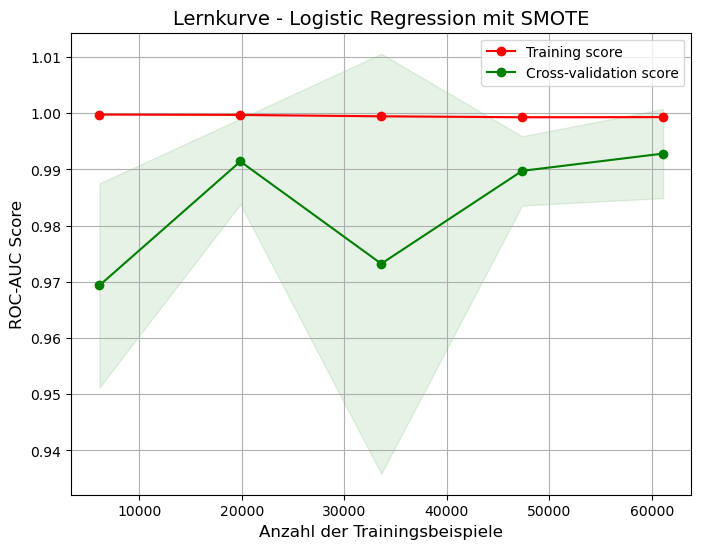

In [49]:
# Lernkurve für Logistic Regression mit SMOTE
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    logreg_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Durchnitt und Standardabweichung der Scores berechnen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Lernkurve plotten
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Lernkurve - Logistic Regression mit SMOTE", fontsize=14)
plt.xlabel("Anzahl der Trainingsbeispiele", fontsize=12)
plt.ylabel("ROC-AUC Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()


## **Lernkurve – Random Forest mit SMOTE**

Die folgende Lernkurve zeigt die Entwicklung der Modellleistung (ROC-AUC) des Random-Forest-Modells in Abhängigkeit von der Anzahl der Trainingsbeispiele. Dabei werden sowohl der Trainings-Score als auch der Cross-Validation-Score dargestellt.

### Beobachtungen

- Der **Trainings-ROC-AUC** liegt über alle Trainingsgrößen hinweg nahezu konstant bei **1.00**.
  - Dies zeigt, dass das Random-Forest-Modell die Trainingsdaten sehr gut lernt.
- Der **Cross-Validation-ROC-AUC** startet bei kleineren Trainingsmengen niedriger, steigt jedoch schnell an und stabilisiert sich bei etwa **0.99**.
- Der Abstand zwischen Trainings- und Validierungsleistung bleibt **gering und stabil**, auch bei zunehmender Datenmenge.

### Interpretation

- Das Modell zeigt **keine Anzeichen von starkem Overfitting**, da die Validierungsleistung sehr nahe an der Trainingsleistung liegt.
- Die Kombination aus **Random Forest und SMOTE** ermöglicht eine robuste Modellierung trotz starker Klassenungleichgewichte.
- Die geringe Varianz der Cross-Validation-Ergebnisse deutet auf eine **hohe Stabilität und gute Generalisierungsfähigkeit** des Modells hin.

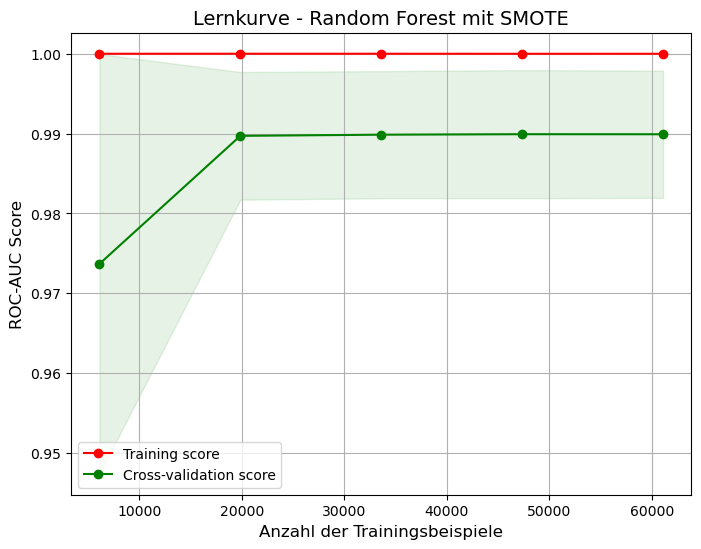

In [50]:
# Lernkurve für Random Forest mit SMOTE
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    rf_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Durchnitt und Standardabweichung der Scores berechnen
train_scores_rf_mean = np.mean(train_scores_rf, axis=1)
train_scores_rf_std = np.std(train_scores_rf, axis=1)
test_scores_rf_mean = np.mean(test_scores_rf, axis=1)
test_scores_rf_std = np.std(test_scores_rf, axis=1)

# Lernkurve plotten
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes_rf, train_scores_rf_mean - train_scores_rf_std,
                 train_scores_rf_mean + train_scores_rf_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_rf, test_scores_rf_mean - test_scores_rf_std,
                 test_scores_rf_mean + test_scores_rf_std, alpha=0.1, color="g")
plt.plot(train_sizes_rf, train_scores_rf_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes_rf, test_scores_rf_mean, "o-", color="g", label="Cross-validation score")
plt.title("Lernkurve - Random Forest mit SMOTE", fontsize=14)
plt.xlabel("Anzahl der Trainingsbeispiele", fontsize=12)
plt.ylabel("ROC-AUC Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()

## **Lernkurve – XGBoost mit SMOTE**

Zur Bewertung der Leistungsfähigkeit und Generalisierungsfähigkeit des XGBoost-Modells wurde ebenfalls eine Lernkurve auf Basis der **ROC-AUC** erstellt.
### Beobachtungen

- Der **Training Score** liegt durchgehend auf einem sehr hohen Niveau (≈ 1.00).
- Der **Cross-Validation Score** nähert sich schnell dem Trainingsniveau an und bleibt über alle Trainingsgrößen hinweg stabil.
- Die Varianz zwischen den einzelnen Cross-Validation-Folds ist gering, insbesondere bei größeren Trainingsmengen.
### Interpretation

- Das Modell zeigt eine **sehr gute Generalisierungsfähigkeit**.
- Der geringe Abstand zwischen Training und Validierung deutet auf ein **ausgewogenes Bias-Variance-Verhältnis** hin.
- XGBoost ist in der Lage, sowohl nicht-lineare Zusammenhänge als auch die durch SMOTE erzeugten synthetischen Daten effektiv zu verarbeiten, ohne stark zu überanpassen.


In [ ]:
# Lernkurve für XGBoost mit SMOTE
train_sizes, train_scores, test_scores = learning_curve(
    xgb_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)
# Durchnitt und Standardabweichung der Scores berechnen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Lernkurve plotten
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Lernkurve - XGBoost mit SMOTE", fontsize=14)
plt.xlabel("Anzahl der Trainingsbeispiele", fontsize=12)
plt.ylabel("ROC-AUC Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()